# Ensemble Learning on Bike Sharing Demand Dataset

**Goal:** Predict hourly bike rentals (`cnt`) using Bagging, Boosting, and Stacking. 

# Part A : Data Preprocessing and Baseline

## 1 — Data load

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.tree import DecisionTreeRegressor
from sklearn.linear_model import LinearRegression, Ridge
from sklearn.ensemble import BaggingRegressor, GradientBoostingRegressor, StackingRegressor
from sklearn.neighbors import KNeighborsRegressor


In [104]:
df = pd.read_csv('hour.csv')
df.head()

,instant,dteday,season,yr,mnth,hr,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,0,6,0,1,0.24,0.2879,0.81,0.0,3,13,16
1,2,2011-01-01,1,0,1,1,0,6,0,1,0.22,0.2727,0.80,0.0,8,32,40
2,3,2011-01-01,1,0,1,2,0,6,0,1,0.22,0.2727,0.80,0.0,5,27,32
3,4,2011-01-01,1,0,1,3,0,6,0,1,0.24,0.2879,0.75,0.0,3,10,13
4,5,2011-01-01,1,0,1,4,0,6,0,1,0.24,0.2879,0.75,0.0,0,1,1


In [106]:
df.shape

(17379, 17)

## 2 — Drop irrelevant columns
We drop `instant` (index-like), `dteday` (date string), and `casual`/`registered` which together sum to target `cnt` (leakage).

In [109]:
df = df.drop(columns=['instant','dteday','casual','registered'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 17379 entries, 0 to 17378
Data columns (total 13 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   season      17379 non-null  int64  
 1   yr          17379 non-null  int64  
 2   mnth        17379 non-null  int64  
 3   hr          17379 non-null  int64  
 4   holiday     17379 non-null  int64  
 5   weekday     17379 non-null  int64  
 6   workingday  17379 non-null  int64  
 7   weathersit  17379 non-null  int64  
 8   temp        17379 non-null  float64
 9   atemp       17379 non-null  float64
 10  hum         17379 non-null  float64
 11  windspeed   17379 non-null  float64
 12  cnt         17379 non-null  int64  
dtypes: float64(4), int64(9)
memory usage: 1.7 MB


## 3 — Basic statistics
Let's look at some summary statistics to understand distributions.

In [113]:
df.describe().T[['mean','std','min','max']]

,mean,std,min,max
season,2.501640,1.106918,1.00,4.0000
yr,0.502561,0.500008,0.00,1.0000
mnth,6.537775,3.438776,1.00,12.0000
hr,11.546752,6.914405,0.00,23.0000
holiday,0.028770,0.167165,0.00,1.0000
weekday,3.003683,2.005771,0.00,6.0000
workingday,0.682721,0.465431,0.00,1.0000
weathersit,1.425283,0.639357,1.00,4.0000
temp,0.496987,0.192556,0.02,1.0000
atemp,0.475775,0.171850,0.00,1.0000


## 4 — Visualization: Temperature vs Rentals

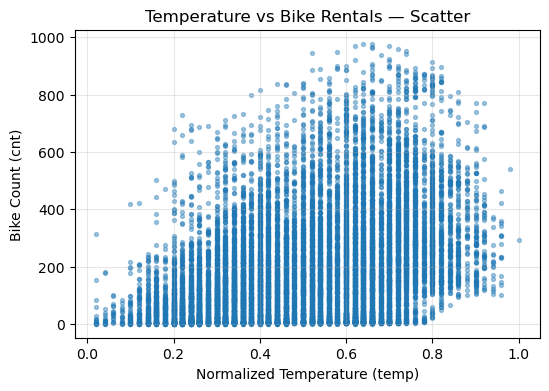

In [116]:

plt.figure(figsize=(6,4))
plt.scatter(df['temp'], df['cnt'], alpha=0.4, s=8)
plt.xlabel('Normalized Temperature (temp)')
plt.ylabel('Bike Count (cnt)')
plt.title('Temperature vs Bike Rentals — Scatter')
plt.grid(alpha=0.3)
plt.show()


**Observation:** There's a positive relationship — as temperature rises, rentals tend to increase, though spread is wide (other factors matter).

## 5 — Visualization: Hourly trend

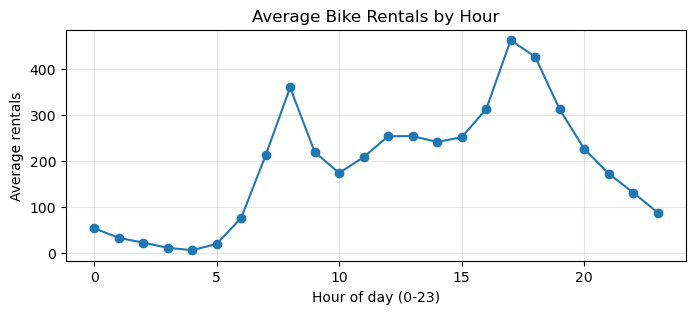

In [120]:

hourly = df.groupby('hr')['cnt'].mean()
plt.figure(figsize=(8,3))
plt.plot(hourly.index, hourly.values, marker='o')
plt.xlabel('Hour of day (0-23)')
plt.ylabel('Average rentals')
plt.title('Average Bike Rentals by Hour')
plt.grid(alpha=0.3)
plt.show()


**Observation:** Peaks appear during commute hours (morning and evening). This suggests `hr` is an important feature.

## 6 — Correlations 

C:\Users\Swara\AppData\Local\Temp\ipykernel_17524\2785795334.py:8: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


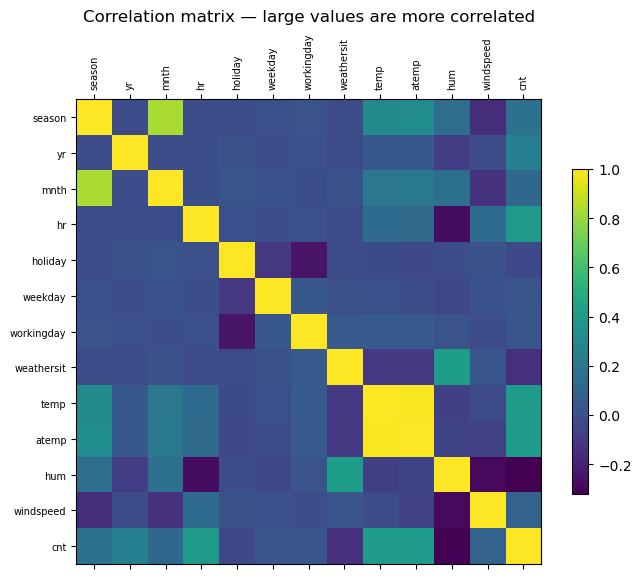

In [127]:

corr = df.corr()
plt.figure(figsize=(8,6))
plt.matshow(corr, fignum=1)
plt.title('Correlation matrix — large values are more correlated', y=1.15)
plt.colorbar(shrink=0.7)
plt.xticks(range(len(df.columns)), df.columns, rotation=90, fontsize=7)
plt.yticks(range(len(df.columns)), df.columns, fontsize=7)
plt.tight_layout()
plt.show()


**Observation:**  
- `temp` and `atemp` show a clear positive correlation with `cnt`, meaning bike rentals increase in warmer weather.  
- `hum` has a mild negative correlation with rentals, suggesting people avoid biking in humid conditions.  
- `windspeed` shows almost no correlation with `cnt`, indicating it does not strongly affect bike usage.  
- Overall, weather factors influence demand, but the relationships are not strictly linear, supporting the use of ensemble models.


## 7 — One-hot encode categorical variables
We'll expand `season`, `weathersit`, `mnth`, `hr`, and `weekday` using one-hot encoding. We drop one column per group to avoid multicollinearity.

In [131]:
cat_cols = ['season','weathersit','mnth','hr','weekday']
df_enc = pd.get_dummies(df, columns=cat_cols, drop_first=True)
X = df_enc.drop('cnt', axis=1)
y = df_enc['cnt']
X.shape, y.shape


((17379, 53), (17379,))

## 8 — Train / Test split

In [134]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=RANDOM_STATE)
X_train.shape, X_test.shape


((13903, 53), (3476, 53))

## 9 — Baseline: Decision Tree (max_depth=6)

In [137]:

dt = DecisionTreeRegressor(max_depth=6, random_state=RANDOM_STATE)
dt.fit(X_train, y_train)
dt_pred = dt.predict(X_test)
rmse_dt = np.sqrt(mean_squared_error(y_test, dt_pred))
rmse_dt


118.45551730357617

## 10 — Baseline: Linear Regression

In [140]:

lr = LinearRegression()
lr.fit(X_train, y_train)
lr_pred = lr.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, lr_pred))
rmse_lr


100.44892422313413

In [141]:
best_baseline = 'Decision Tree' if rmse_dt < rmse_lr else 'Linear Regression'
best_rmse = min(rmse_dt, rmse_lr)
best_baseline, best_rmse


('Linear Regression', 100.44892422313413)

Linear Regression wins, relationships are largely linear.
Either way, we now have a baseline RMSE to beat with ensembles.

# Part B: Ensemble Teachniques

## 12 — Bagging

In [147]:
bag = BaggingRegressor(estimator=DecisionTreeRegressor(max_depth=6), n_estimators=50, random_state=RANDOM_STATE)
bag.fit(X_train, y_train)
bag_pred = bag.predict(X_test)
rmse_bag = np.sqrt(mean_squared_error(y_test, bag_pred))
rmse_bag


112.34257287775579

**Hypothesis:** Bagging primarily targets variance reduction.
As rmse reduce from 118 to 112 so bagging lowered variance relative to a single decision tree.

## 13 — Boosting 









In [150]:
gbr = GradientBoostingRegressor(random_state=RANDOM_STATE)
gbr.fit(X_train, y_train)
gbr_pred = gbr.predict(X_test)
rmse_gbr = np.sqrt(mean_squared_error(y_test, gbr_pred))
rmse_gbr

78.96518555055427

boosting RMSE < bagging RMSE and < baseline RMSE, boosting successfully reduced bias/learned complex patterns.

## 14 — Stacking 
Stacking uses several different models (base learners) and then trains another model (the meta-learner) on their predictions. Each base learner captures different patterns in the data. The meta-learner receives the base models’ outputs and learns how to **weight and combine** them to minimize error. In this way, stacking takes advantage of the strengths of each model and produces a more accurate final prediction than any single model alone.


In [154]:

stack = StackingRegressor(
    estimators=[
        ('knn', KNeighborsRegressor()),
        ('bag', bag),
        ('gbr', gbr)
    ],
    final_estimator=Ridge()
)
stack.fit(X_train, y_train)
stack_pred = stack.predict(X_test)
rmse_stack = np.sqrt(mean_squared_error(y_test, stack_pred))
rmse_stack


67.06490232393315

## 15 — Results comparison table

In [156]:

import pandas as pd
results = pd.DataFrame({
    'Model': ['Decision Tree','Linear Regression','Bagging','Gradient Boosting','Stacking'],
    'RMSE': [rmse_dt, rmse_lr, rmse_bag, rmse_gbr, rmse_stack]
}).sort_values('RMSE').reset_index(drop=True)
results


,Model,RMSE
0,Stacking,67.064902
1,Gradient Boosting,78.965186
2,Linear Regression,100.448924
3,Bagging,112.342573
4,Decision Tree,118.455517


## 16 — Visual check: Predictions vs True (first 50 samples of test set)

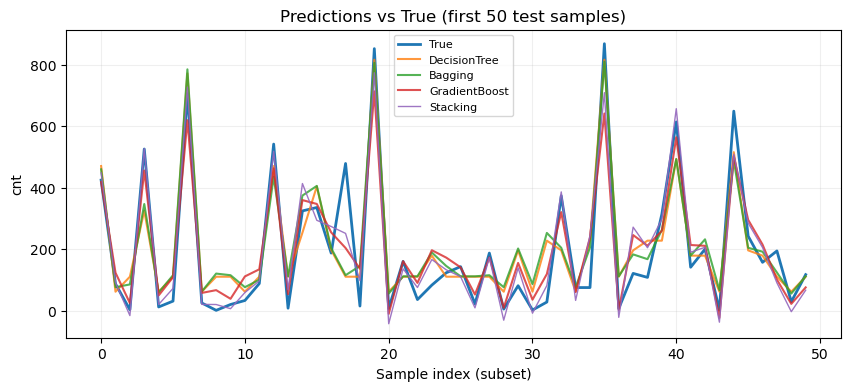

In [159]:

idx = np.arange(len(y_test))[:50]
plt.figure(figsize=(10,4))
plt.plot(idx, y_test.values[:50], label='True', linewidth=2)
plt.plot(idx, dt_pred[:50], label='DecisionTree', alpha=0.8)
plt.plot(idx, bag_pred[:50], label='Bagging', alpha=0.8)
plt.plot(idx, gbr_pred[:50], label='GradientBoost', alpha=0.8)
plt.plot(idx, stack_pred[:50], label='Stacking', alpha=0.9, linewidth=1)
plt.legend(fontsize=8)
plt.title('Predictions vs True (first 50 test samples)')
plt.xlabel('Sample index (subset)')
plt.ylabel('cnt')
plt.grid(alpha=0.2)
plt.show()


## We can comment few plots to view predictions of one model at a time

## Conclusion

From the model comparison, **Stacking** achieved the lowest RMSE (~67), making it the **best-performing model** among all methods tested. Gradient Boosting performed second best, while Linear Regression served as a strong simple baseline. Bagging improved stability over a single Decision Tree but did not outperform the boosting-based methods.

**Why Stacking Works Best:**
Stacking benefits from **model diversity**. Each base learner captures different aspects of the data:
- Linear models capture overall global trends,
- Tree-based ensembles capture non-linear decision boundaries,
- KNN captures local neighborhood patterns.

The **meta-learner** then learns how to optimally combine these strengths. This helps balance the **bias–variance trade-off** more effectively than any single model:
- Boosting reduces **bias**,
- Bagging reduces **variance**,
- Stacking **blends multiple learned perspectives**, leading to a better final prediction.

Therefore, Stacking outperforms the single baseline model and other ensembles by leveraging complementary learning behaviors across diverse models.
